In [1]:
import os
from enum import auto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

Call database 10-20 hours

In [2]:
## Open the file
Data_raw = pd.read_csv(r"Y:\36 TP\MAPbBr3\Paper ML crystal\DB_model2.csv", 
                                delimiter = ",")

Call database 20-end

In [2]:
## Open the file
Data_raw_20_e = pd.read_csv(r"Y:\36 TP\MAPbBr3\Paper ML crystal\DB_model3.csv", 
                                delimiter = ",")

For the 10-20 hours database

In [1]:
# Instead of separated sizes, creating the seed area
Data_raw ['Seed crystal mm2'] = (Data_raw['Seed Size A (mm)']*
                                      Data_raw['Seed Size B (mm)'])

NameError: name 'Data_raw' is not defined

In [4]:
#Removing non-desired features from the raw data - categorical, constants, values obtained in the end and imaging related features
Data_raw = Data_raw.drop(['Hotplate', 'Last Syringe Mass (g)',
                            'Last Solution Mass (g)', 'Last Total Mass (g)',
                            'All Deposited Crystals (g)', 'Total Infusion (g)', 'Total Evaporation (g)', 
                            'Estimated Last Concentration (wt.%)', 'Hotplate Temperature (oC)',
                            'Syringe Diameter (mm)', 'Imaging Width (pixel)',
                            'Imaging Height (pixel)', 'Shot Interval (sec)', 'Mask Radius (pixel)',
                            'Scale (pixel/mm2)', 'B Bottom Threshold', 'G Bottom Threshold',
                            'R Bottom Threshold', 'B Top Threshold', 'G Top Threshold',
                            'R Top Threshold', 'L Smoothing Parameters 1',
                            'L Smoothing Parameters 2', 'G Smoothing Parameters 1',
                            'G Smoothing Parameters 2', 'Smoothed Growth Rate (mm/h)', 'Smoothed Length (mm)',
                            'source', 'Unnamed: 0', 'source.1'], axis=1)

In [ ]:
# Correlation plot
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(Data_raw.corr(), vmin=-1, vmax=1, annot=False, 
                    cmap= cm.vik, #'viridis', #cmocean.cm.matter,
                    square=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')
# Name file
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\corr_plot_10_20_1st.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


In [5]:
# Removing non-desired features from the raw data - correlated and redundant features
Data_raw = Data_raw.drop(['Crystal Size A (mm)', 'Crystal Size B (mm)', 'Crystal Size C (mm)', 'Number of Crystals',
                            'integral e', 'Length (mm)', 'Kp', 'Ki', 'Kd', 'de/dt', 'e(t)',
                            'Initial Infusion Rate (mL/h)', 'Total Infusion (mL)',
                            'Initial Syringe Mass (g)', 'Initial Total Mass (g)',
                            'Est-Mass (g)', 'Initial Concentration (wt.%)', 'Estimated Evaporation Rate (g/h)',
                            'Seed crystal mm2', 'Seed Size A (mm)', 'Seed Size B (mm)', 'Seed Size C (mm)'], axis=1)

In [6]:
Data_final = Data_raw

In [7]:
# Rename columns
Data_final = Data_final.rename(columns=
                                 {'Initial Solution Mass (g)':'Initial_Solution_Mass',
                                  'Room Temperature (oC)':'Room_Temperature', 
                                  'Humidity (RH%)': 'Humidity',
                                  'Evaporation Rate (g/h)': 'Evaporation_Rate',
                                  'Ideal Growth Rate (mm/h)': 'Ideal_Growth_Rate', 
                                  'Time (h)': 'Time', 
                                  'Infusion Rate (mL/h)': 'Infusion_Rate',
                                  'Area (mm2)': 'Area', 
                                  'Growth Rate (mm/h)': 'Growth_Rate', 
                                  'Estimated Concentration (wt.%)': 'Estimated_Concentration'})

In [8]:
# New order of columns
new_order = ['Initial_Solution_Mass', 'Room_Temperature', 'Humidity',
       'Evaporation_Rate', 'Ideal_Growth_Rate', 'Infusion_Rate', 'Time',
       'Area', 'Growth_Rate', 'Estimated_Concentration']

Data_final = Data_final.reindex(columns=new_order)

In [9]:
# Removing NA values and negative values from evaporation rate and estimated concentration
Data_final = Data_final.dropna()
Data_final = Data_final[Data_final['Evaporation_Rate'] >= 0]
Data_final = Data_final[Data_final['Estimated_Concentration'] >= 0]

In [ ]:
# Correlation plot
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(Data_raw.corr(), vmin=-1, vmax=1, annot=False, 
                    cmap= cm.vik,
                    square=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

# Name file
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\corr_plot_10_20_2nd.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Models development/training

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
from pprint import pprint
from hyperopt import hp, fmin, tpe, space_eval, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

In [11]:
## x and y subsets
x = Data_final.drop(['Evaporation_Rate'], axis=1)
y = Data_final[['Evaporation_Rate']]

np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=25) # 75% training and 25% test

Decision Trees

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(1, 800)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2, 500)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_weight_fraction_leaf': hp.choice('min_weight_fraction_leaf', [0.1])
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    dt = DecisionTreeRegressor(**params)
    scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    return rmse

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Create a Decision Tree regressor with the best hyperparameters
dt = DecisionTreeRegressor(**best_params)
scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

dt.fit(X_train, y_train)

# Prediction on test set
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

print(best_params)

In [12]:
## Optimized model for decision trees
# Create the parameter grid based on the results of random search - using hyperopt   --- decision trees
best_params = {
              'max_depth': 423, 
              'max_features':1.0, 
              'max_leaf_nodes': 119,
              'min_weight_fraction_leaf': 0.1, 
              'min_samples_leaf': 7,
              'min_samples_split': 8 
}
# Create a Decision Tree regressor with the best hyperparameters
dt = DecisionTreeRegressor(**best_params)
dt.fit(X_train, y_train)

# Prediction on test set
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

In [ ]:
# Training metrics
MAE_train_dt = pd.DataFrame(mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train_dt = pd.DataFrame(np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train_dt = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))
train_metrics_dt = pd.concat([MAE_train_dt, RMSE_train_dt, R2_train_dt], axis='columns')
train_metrics_dt.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_dt)

# Test metrics
MAE_test_dt = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_dt = pd.DataFrame(np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_dt = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))
test_metrics_dt = pd.concat([MAE_test_dt, RMSE_test_dt, R2_test_dt], axis='columns')
test_metrics_dt.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_dt)

Random Forest

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.choice('max_depth', range(1, 100)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 500))
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    rf = RandomForestRegressor(**params)
    scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean()) 
    return rmse

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2, trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Create a Random Forest regressor with the best hyperparameters
rf = RandomForestRegressor(**best_params)
scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error')

rf.fit(X_train, y_train)

# Prediction on test set
y_pred = rf.predict(X_test)


print(best_params)

In [19]:
# random forest optimized
 #### after defined the search space
best_params = {
    'bootstrap': False,
    'max_depth': 550,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 4,
    'n_estimators': 250,
}

rf = RandomForestRegressor(**best_params)
rf.fit(X_train, np.ravel(y_train)) 

# Prediction on test set
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [ ]:
# Training metrics
MAE_train_rf = pd.DataFrame(mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train_rf = pd.DataFrame(np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train_rf = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))
train_metrics_rf = pd.concat([MAE_train_rf, RMSE_train_rf, R2_train_rf], axis='columns')
train_metrics_rf.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_rf)

# Test metrics
MAE_test_rf = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_rf = pd.DataFrame(np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_rf = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))
test_metrics_rf = pd.concat([MAE_test_rf, RMSE_test_rf, R2_test_rf], axis='columns')
test_metrics_rf.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_rf)

XGBoost

In [ ]:
#hyperopt
####### to optimize hyperparameters, do the lines below
# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(20, 50)),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.08),
    'n_estimators': hp.choice('n_estimators', range(400,1000)),
    'gamma': hp.uniform('gamma', 0.3, 0.7),
    'min_child_weight': hp.choice('min_child_weight', range(5, 15)),
    'subsample': hp.uniform('subsample', 0.1, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 0.8)
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    xgb_reg = xgb.XGBRegressor(**params, random_state=42)
    scores = cross_val_score(xgb_reg, X_train, y_train, cv=cv, scoring='r2')
    rmse = np.sqrt(-scores.mean()) 
    return rmse 


# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Create a Decision Tree regressor with the best hyperparameters
xgb = xgb.XGBRegressor(**best_params)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

xgb.fit(X_train, y_train)

# Prediction on test set
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

print(best_params)

In [16]:
# xgboost optimized with hyperopt

best_params = {
    'max_depth': 10,
    'learning_rate': 0.04,
    'n_estimators': 1000,
    'gamma': 0.1,
    'min_child_weight': 10,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 1,
    'alpha': 0
}

# Create a Random Forest regressor with the best hyperparameters - hyperopt
xgb = xgb.XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

# Prediction on test set
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

In [ ]:
# Training metrics
MAE_train_xgb = pd.DataFrame(mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train_xgb = pd.DataFrame(np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train_xgb = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))
train_metrics_xgb = pd.concat([MAE_train_xgb, RMSE_train_xgb, R2_train_xgb], axis='columns')
train_metrics_xgb.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_xgb)

# Test metrics
MAE_test_xgb = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_xgb = pd.DataFrame(np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_xgb = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))
test_metrics_xgb = pd.concat([MAE_test_xgb, RMSE_test_xgb, R2_test_xgb], axis='columns')
test_metrics_xgb.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_xgb)

SHAP and Feature Importance

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from pprint import pprint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import shap

Decision trees

In [ ]:
# Features importance by permutation
result = permutation_importance(dt, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test.columns[i] for i in indices]

n_colors = len(sorted_importances) 
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

# Name file
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_DT_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# SHAP plot
N = 1000
X_sample = X_test.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(dt, data=X_test)
shap_values = explainer.shap_values(X_sample, check_additivity=False)
feature_names = X_test.columns.astype(str)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
shap.initjs()

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_DT_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Random forest

In [ ]:
# Feature importance by permutation
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test.columns[i] for i in indices]

n_colors = len(sorted_importances)  
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_RF_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# SHAP plot
N = 1000
X_sample = X_test.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(rf, data=X_test)

shap_values = explainer.shap_values(X_sample, check_additivity=False)

feature_names = X_test.columns.astype(str)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

shap.initjs()

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_RF_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

XGBoost

In [ ]:
# Feature importance by permutation
result = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test.columns[i] for i in indices]

n_colors = len(sorted_importances) 
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_XGB_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# SHAP plot
N = 1000
X_sample = X_test.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(xgb, data=X_test)

shap_values = explainer.shap_values(X_sample, check_additivity=False)

feature_names = X_test.columns.astype(str)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

shap.initjs()

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_XGB_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Parity plots

Decision trees

In [ ]:
# Parity for DT
colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train, y_pred_train, color=train_color, s=30, label='Train set')

ax.scatter(y_test, y_pred, color=test_color, s=30, label='Test set')

ax.plot([min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        [min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        color='black', linestyle='--')

ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=18, frameon = False, loc='upper left')

fig.set_dpi(500)

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_DT_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


Random Forest

In [ ]:
# Parity - RF
colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train, y_pred_train, color=train_color, s=30, label='Train set')

ax.scatter(y_test, y_pred, color=test_color, s=30, label='Test set')

ax.plot([min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        [min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        color='black', linestyle='--')

ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=18, frameon = False, loc='upper left')

fig.set_dpi(500)

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_RF_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


XGBoost

In [ ]:
# Parity - XGBoost
colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train, y_pred_train, color=train_color, s=30, label='Train set')

ax.scatter(y_test, y_pred, color=test_color, s=30, label='Test set')

ax.plot([min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        [min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        color='black', linestyle='--')

ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=18, frameon = False, loc='upper left')

fig.set_dpi(500)

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_XGBoost_10_20.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


Model 3 - 20 hours to end database

In [3]:
# Instead of separated sizes, creating the seed area
Data_raw_20_e ['Seed crystal mm2'] = (Data_raw_20_e['Seed Size A (mm)']*
                                      Data_raw_20_e['Seed Size B (mm)'])

In [4]:
#Removing non-desired features from the raw data - categorical, constants, values obtained in the end and imaging related features
Data_raw_20_e = Data_raw_20_e.drop(['Hotplate', 'Last Syringe Mass (g)',
                            'Last Solution Mass (g)', 'Last Total Mass (g)',
                            'All Deposited Crystals (g)', 'Total Infusion (g)', 'Total Evaporation (g)', 
                            'Estimated Last Concentration (wt.%)', 'Hotplate Temperature (oC)',
                            'Syringe Diameter (mm)', 'Imaging Width (pixel)',
                            'Imaging Height (pixel)', 'Shot Interval (sec)', 'Mask Radius (pixel)',
                            'Scale (pixel/mm2)', 'B Bottom Threshold', 'G Bottom Threshold',
                            'R Bottom Threshold', 'B Top Threshold', 'G Top Threshold',
                            'R Top Threshold', 'L Smoothing Parameters 1',
                            'L Smoothing Parameters 2', 'G Smoothing Parameters 1',
                            'G Smoothing Parameters 2', 'Smoothed Growth Rate (mm/h)', 'Smoothed Length (mm)',
                            'source', 'Unnamed: 0', 'source.1'], axis=1)

In [ ]:
# Correlation plot
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(Data_raw_20_e.corr(), vmin=-1, vmax=1, annot=False, 
                    cmap= cm.vik, #'viridis', #cmocean.cm.matter,
                    square=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\corr_plot_20_end_1st.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


In [5]:
# Removing non-desired features from the raw data - correlated and redundant features
Data_raw_20_e = Data_raw_20_e.drop(['Crystal Size A (mm)', 'Crystal Size B (mm)', 'Crystal Size C (mm)', 'Number of Crystals',
                            'integral e', 'Length (mm)', 'Kp', 'Ki', 'Kd', 'de/dt', 'e(t)',
                            'Initial Infusion Rate (mL/h)', 'Total Infusion (mL)',
                            'Initial Syringe Mass (g)', 'Initial Total Mass (g)',
                            'Est-Mass (g)', 'Initial Concentration (wt.%)', 'Estimated Evaporation Rate (g/h)',
                            'Seed crystal mm2', 'Seed Size A (mm)', 'Seed Size B (mm)', 'Seed Size C (mm)'], axis=1)

In [6]:
Data_final_20_e = Data_raw_20_e

In [7]:
# Rename columns
Data_final_20_e = Data_final_20_e.rename(columns=
                                 {'Initial Solution Mass (g)':'Initial_Solution_Mass',
                                  'Room Temperature (oC)':'Room_Temperature', 
                                  'Humidity (RH%)': 'Humidity',
                                  'Evaporation Rate (g/h)': 'Evaporation_Rate',
                                  'Ideal Growth Rate (mm/h)': 'Ideal_Growth_Rate', 
                                  'Time (h)': 'Time', 
                                  'Infusion Rate (mL/h)': 'Infusion_Rate',
                                  'Area (mm2)': 'Area', 
                                  'Growth Rate (mm/h)': 'Growth_Rate', 
                                  'Estimated Concentration (wt.%)': 'Estimated_Concentration'})

In [8]:
# New order of columns
new_order = ['Initial_Solution_Mass', 'Room_Temperature', 'Humidity',
       'Evaporation_Rate', 'Ideal_Growth_Rate', 'Infusion_Rate', 'Time',
       'Area', 'Growth_Rate', 'Estimated_Concentration']

Data_final_20_e = Data_final_20_e.reindex(columns=new_order)

In [9]:
# Removing NA values and negative values from evaporation rate and estimated concentration
Data_final_20_e = Data_final_20_e.dropna()
Data_final_20_e = Data_final_20_e[Data_final_20_e['Evaporation_Rate'] >= 0]
Data_final_20_e = Data_final_20_e[Data_final_20_e['Estimated_Concentration'] >= 0]

In [ ]:
# Correlation plot
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(Data_final_20_e.corr(), vmin=-1, vmax=1, annot=False, 
                    cmap= cm.vik,
                    square=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\corr_plot_20_end_2nd.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Models development/training

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
from pprint import pprint
from hyperopt import hp, fmin, tpe, space_eval, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

In [11]:
## x and y subsets
x_20_e = Data_final_20_e.drop(['Evaporation_Rate'], axis=1)
y_20_e = Data_final_20_e[['Evaporation_Rate']]

np.random.seed(100)
X_train_20_e, X_test_20_e, y_train_20_e, y_test_20_e = train_test_split(x_20_e, y_20_e, test_size=0.25, random_state=25) # 75% training and 25% test

Decision Trees

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space_20_e = {
    'max_depth': hp.choice('max_depth', range(1, 800)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2, 500)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_weight_fraction_leaf': hp.choice('min_weight_fraction_leaf', [0.1])
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    dt_20_e = DecisionTreeRegressor(**params)
    scores = cross_val_score(dt_20_e, X_train_20_e, y_train_20_e, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean()) 
    return rmse

# Run the hyperparameter optimization
trials = Trials()
best_20_e = fmin(fn=objective, space=space_20_e, algo=tpe.suggest, max_evals=200, trials=trials)

# Get the best hyperparameters
best_params_20_e = space_eval(space, best_20_e)

# Create a Decision Tree regressor with the best hyperparameters
dt_20_e = DecisionTreeRegressor(**best_params)
scores_20_e = cross_val_score(dt_20_e, X_train_20_e, y_train_20_e, cv=cv, scoring='neg_mean_squared_error')

dt_20_e.fit(X_train_20_e, y_train_20_e)

# Prediction on test set
y_pred_20_e = dt_20_e.predict(X_test_20_e)
y_pred_train_20_e = dt_20_e.predict(X_train_20_e)

print(best_params_20_e)

In [12]:
## Optimized model for decision trees
# Create the parameter grid based on the results of random search - using hyperopt   --- decision trees
best_params_20_e = {
              'max_depth': 423, 
              'max_features':1.0, 
              'max_leaf_nodes': 119,
              'min_weight_fraction_leaf': 0.1, 
              'min_samples_leaf': 7,
              'min_samples_split': 8 
}
# Create a Decision Tree regressor with the best hyperparameters
dt_20_e = DecisionTreeRegressor(**best_params_20_e)
dt_20_e.fit(X_train_20_e, y_train_20_e)

# Prediction on test set
y_pred_20_e = dt_20_e.predict(X_test_20_e)
y_pred_train_20_e = dt_20_e.predict(X_train_20_e)

In [13]:
# Training metrics
MAE_train_dt_20_e = pd.DataFrame(mean_absolute_error(y_train_20_e, y_pred_train_20_e, multioutput='raw_values'))
RMSE_train_dt_20_e = pd.DataFrame(np.sqrt(mean_squared_error(y_train_20_e, y_pred_train_20_e, multioutput='raw_values')))
R2_train_dt_20_e = pd.DataFrame(r2_score(y_train_20_e, y_pred_train_20_e, multioutput='raw_values'))
train_metrics_dt_20_e = pd.concat([MAE_train_dt_20_e, RMSE_train_dt_20_e, R2_train_dt_20_e], axis='columns')
train_metrics_dt_20_e.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_dt_20_e)

# Test metrics
MAE_test_dt_20_e = pd.DataFrame(mean_absolute_error(y_test_20_e, y_pred_20_e, multioutput='raw_values'))
RMSE_test_dt_20_e = pd.DataFrame(np.sqrt(mean_squared_error(y_test_20_e, y_pred_20_e, multioutput='raw_values')))
R2_test_dt_20_e = pd.DataFrame(r2_score(y_test_20_e, y_pred_20_e, multioutput='raw_values'))
test_metrics_dt_20_e = pd.concat([MAE_test_dt_20_e, RMSE_test_dt_20_e, R2_test_dt_20_e], axis='columns')
test_metrics_dt_20_e.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_dt_20_e)

   MAE_train  RMSE_train  R2_train
0   0.224559    0.346528  0.392807
   MAE_test  RMSE_test   R2_test
0  0.224193   0.345867  0.391316


Random Forest

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space_20_e = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.choice('max_depth', range(1, 100)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 500))
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    rf_20_e = RandomForestRegressor(**params)
    scores = cross_val_score(rf_20_e, X_train_20_e, y_train_20_e, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    return rmse

# Run the hyperparameter optimization
trials = Trials()
best_20_e = fmin(fn=objective, space=space_20_e, algo=tpe.suggest, max_evals=2, trials=trials)

# Get the best hyperparameters
best_params_20_e = space_eval(space_20_e, best_20_e)

# Create a Random Forest regressor with the best hyperparameters
rf_20_e = RandomForestRegressor(**best_params_20_e)
scores = cross_val_score(rf_20_e, X_train_20_e, y_train_20_e, scoring='neg_mean_squared_error')

rf_20_e.fit(X_train_20_e, y_train_20_e)

# Prediction on test set
y_pred_20_e = rf_20_e.predict(X_test_20_e)


print(best_params_20_e)

In [20]:
# random forest optimized
 #### after defined the search space
best_params_20_e = {
    'bootstrap': False,
    'max_depth': 550,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 4,
    'n_estimators': 250,
}

rf_20_e = RandomForestRegressor(**best_params_20_e)
rf_20_e.fit(X_train_20_e, np.ravel(y_train_20_e)) 


# Prediction on test set
y_pred_20_e = rf_20_e.predict(X_test_20_e)
y_pred_train_20_e = rf_20_e.predict(X_train_20_e)

In [21]:
# Training metrics
MAE_train_rf_20_e = pd.DataFrame(mean_absolute_error(y_train_20_e, y_pred_train_20_e, multioutput='raw_values'))
RMSE_train_rf_20_e = pd.DataFrame(np.sqrt(mean_squared_error(y_train_20_e, y_pred_train_20_e, multioutput='raw_values')))
R2_train_rf_20_e = pd.DataFrame(r2_score(y_train_20_e, y_pred_train_20_e, multioutput='raw_values'))
train_metrics_rf_20_e = pd.concat([MAE_train_rf_20_e, RMSE_train_rf_20_e, R2_train_rf_20_e], axis='columns')
train_metrics_rf_20_e.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_rf_20_e)

# Test metrics
MAE_test_rf_20_e = pd.DataFrame(mean_absolute_error(y_test_20_e, y_pred_20_e, multioutput='raw_values'))
RMSE_test_rf_20_e = pd.DataFrame(np.sqrt(mean_squared_error(y_test_20_e, y_pred_20_e, multioutput='raw_values')))
R2_test_rf_20_e = pd.DataFrame(r2_score(y_test_20_e, y_pred_20_e, multioutput='raw_values'))
test_metrics_rf_20_e = pd.concat([MAE_test_rf_20_e, RMSE_test_rf_20_e, R2_test_rf_20_e], axis='columns')
test_metrics_rf_20_e.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_rf_20_e)

   MAE_train  RMSE_train  R2_train
0   0.000002    0.000078       1.0
   MAE_test  RMSE_test  R2_test
0  0.000007   0.000257      1.0


XGBoost

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space_20_e = {
    'max_depth': hp.choice('max_depth', range(20, 50)),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.08),
    'n_estimators': hp.choice('n_estimators', range(400,1000)),
    'gamma': hp.uniform('gamma', 0.3, 0.7),
    'min_child_weight': hp.choice('min_child_weight', range(5, 15)),
    'subsample': hp.uniform('subsample', 0.1, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 0.8)
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    xgb_reg_20_e = xgb.XGBRegressor(**params, random_state=42)
    scores = cross_val_score(xgb_reg_20_e, X_train_20_e, y_train_20_e, cv=cv, scoring='r2')
    #rmse = np.sqrt(-scores.mean())  # Negative mean squared error to minimize
    mean_r2 = scores.mean()
    return -mean_r2 

# Run the hyperparameter optimization
trials = Trials()
best_20_e = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

# Get the best hyperparameters
best_params_20_e = space_eval(space_20_e, best_20_e)

# Create a Decision Tree regressor with the best hyperparameters
xgb_20_e = xgb.XGBRegressor(**best_params_20_e)
scores = cross_val_score(xgb_20_e, X_train_20_e, y_train_20_e, cv=cv, scoring='neg_mean_squared_error')

xgb.fit(X_train_20_e, y_train_20_e)

# Prediction on test set
y_pred_20_e = xgb.predict(X_test_20_e)
y_pred_train_20_e = xgb.predict(X_train_20_e)

print(best_params_20_e)

In [17]:
# xgboost optimized with hyperopt

best_params_20_e = {
    'max_depth': 10,
    'learning_rate': 0.04,
    'n_estimators': 1000,
    'gamma': 0.1,
    'min_child_weight': 10,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 1,
    'alpha': 0
}

# Create a Random Forest regressor with the best hyperparameters - hyperopt
xgb_20_e = xgb.XGBRegressor(**best_params_20_e)
xgb_20_e.fit(X_train_20_e, y_train_20_e)

# Prediction on test set
y_pred_20_e = xgb_20_e.predict(X_test_20_e)
y_pred_train_20_e = xgb_20_e.predict(X_train_20_e)

In [18]:
# Training metrics
MAE_train_xgb_20_e = pd.DataFrame(mean_absolute_error(y_train_20_e, y_pred_train_20_e, multioutput='raw_values'))
RMSE_train_xgb_20_e = pd.DataFrame(np.sqrt(mean_squared_error(y_train_20_e, y_pred_train_20_e, multioutput='raw_values')))
R2_train_xgb_20_e = pd.DataFrame(r2_score(y_train_20_e, y_pred_train_20_e, multioutput='raw_values'))
train_metrics_xgb_20_e = pd.concat([MAE_train_xgb_20_e, RMSE_train_xgb_20_e, R2_train_xgb_20_e], axis='columns')
train_metrics_xgb_20_e.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_xgb_20_e)

# Test metrics
MAE_test_xgb_20_e = pd.DataFrame(mean_absolute_error(y_test_20_e, y_pred_20_e, multioutput='raw_values'))
RMSE_test_xgb_20_e = pd.DataFrame(np.sqrt(mean_squared_error(y_test_20_e, y_pred_20_e, multioutput='raw_values')))
R2_test_xgb_20_e = pd.DataFrame(r2_score(y_test_20_e, y_pred_20_e, multioutput='raw_values'))
test_metrics_xgb_20_e = pd.concat([MAE_test_xgb_20_e, RMSE_test_xgb_20_e, R2_test_xgb_20_e], axis='columns')
test_metrics_xgb_20_e.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_xgb_20_e)

   MAE_train  RMSE_train  R2_train
0   0.005799    0.009109   0.99958
   MAE_test  RMSE_test   R2_test
0  0.005813   0.009155  0.999574


SHAP and Features importance

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from pprint import pprint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import shap

Decision Trees

In [ ]:
# Features importance by permutation
result = permutation_importance(dt_20_e, X_test_20_e, y_test_20_e, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test_20_e.columns[i] for i in indices]

n_colors = len(sorted_importances)  
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_DT_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# SHAP plot

N = 1000
X_sample_20_e = X_test_20_e.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(dt_20_e, data=X_test_20_e)

shap_values = explainer.shap_values(X_sample_20_e, check_additivity=False)

feature_names = X_test_20_e.columns.astype(str)

shap.summary_plot(shap_values, X_sample_20_e, feature_names=feature_names, show=False)

shap.initjs()

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_DT_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Random Forest

In [ ]:
# Features importance by permutation
result = permutation_importance(rf_20_e, X_test_20_e, y_test_20_e, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test_20_e.columns[i] for i in indices]

n_colors = len(sorted_importances)
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_RF_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# SHAP plot - RF

N = 1000
X_sample_20_e = X_test_20_e.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(rf_20_e, data=X_test_20_e)

shap_values = explainer.shap_values(X_sample_20_e, check_additivity=False)

feature_names = X_test_20_e.columns.astype(str)

shap.summary_plot(shap_values, X_sample_20_e, feature_names=feature_names, show=False)

shap.initjs()

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_RF_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

XGBoost

In [ ]:
# Features importance by permutation
result = permutation_importance(xgb_20_e, X_test_20_e, y_test_20_e, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test_20_e.columns[i] for i in indices]

n_colors = len(sorted_importances)
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_XGB_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# SHAP plot

N = 1000
X_sample_20_e = X_test_20_e.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(xgb_20_e, data=X_test_20_e)

shap_values = explainer.shap_values(X_sample_20_e, check_additivity=False)

feature_names = X_test_20_e.columns.astype(str)

shap.summary_plot(shap_values, X_sample_20_e, feature_names=feature_names, show=False)

shap.initjs()

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_XGB_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Parity plots

Decision Trees

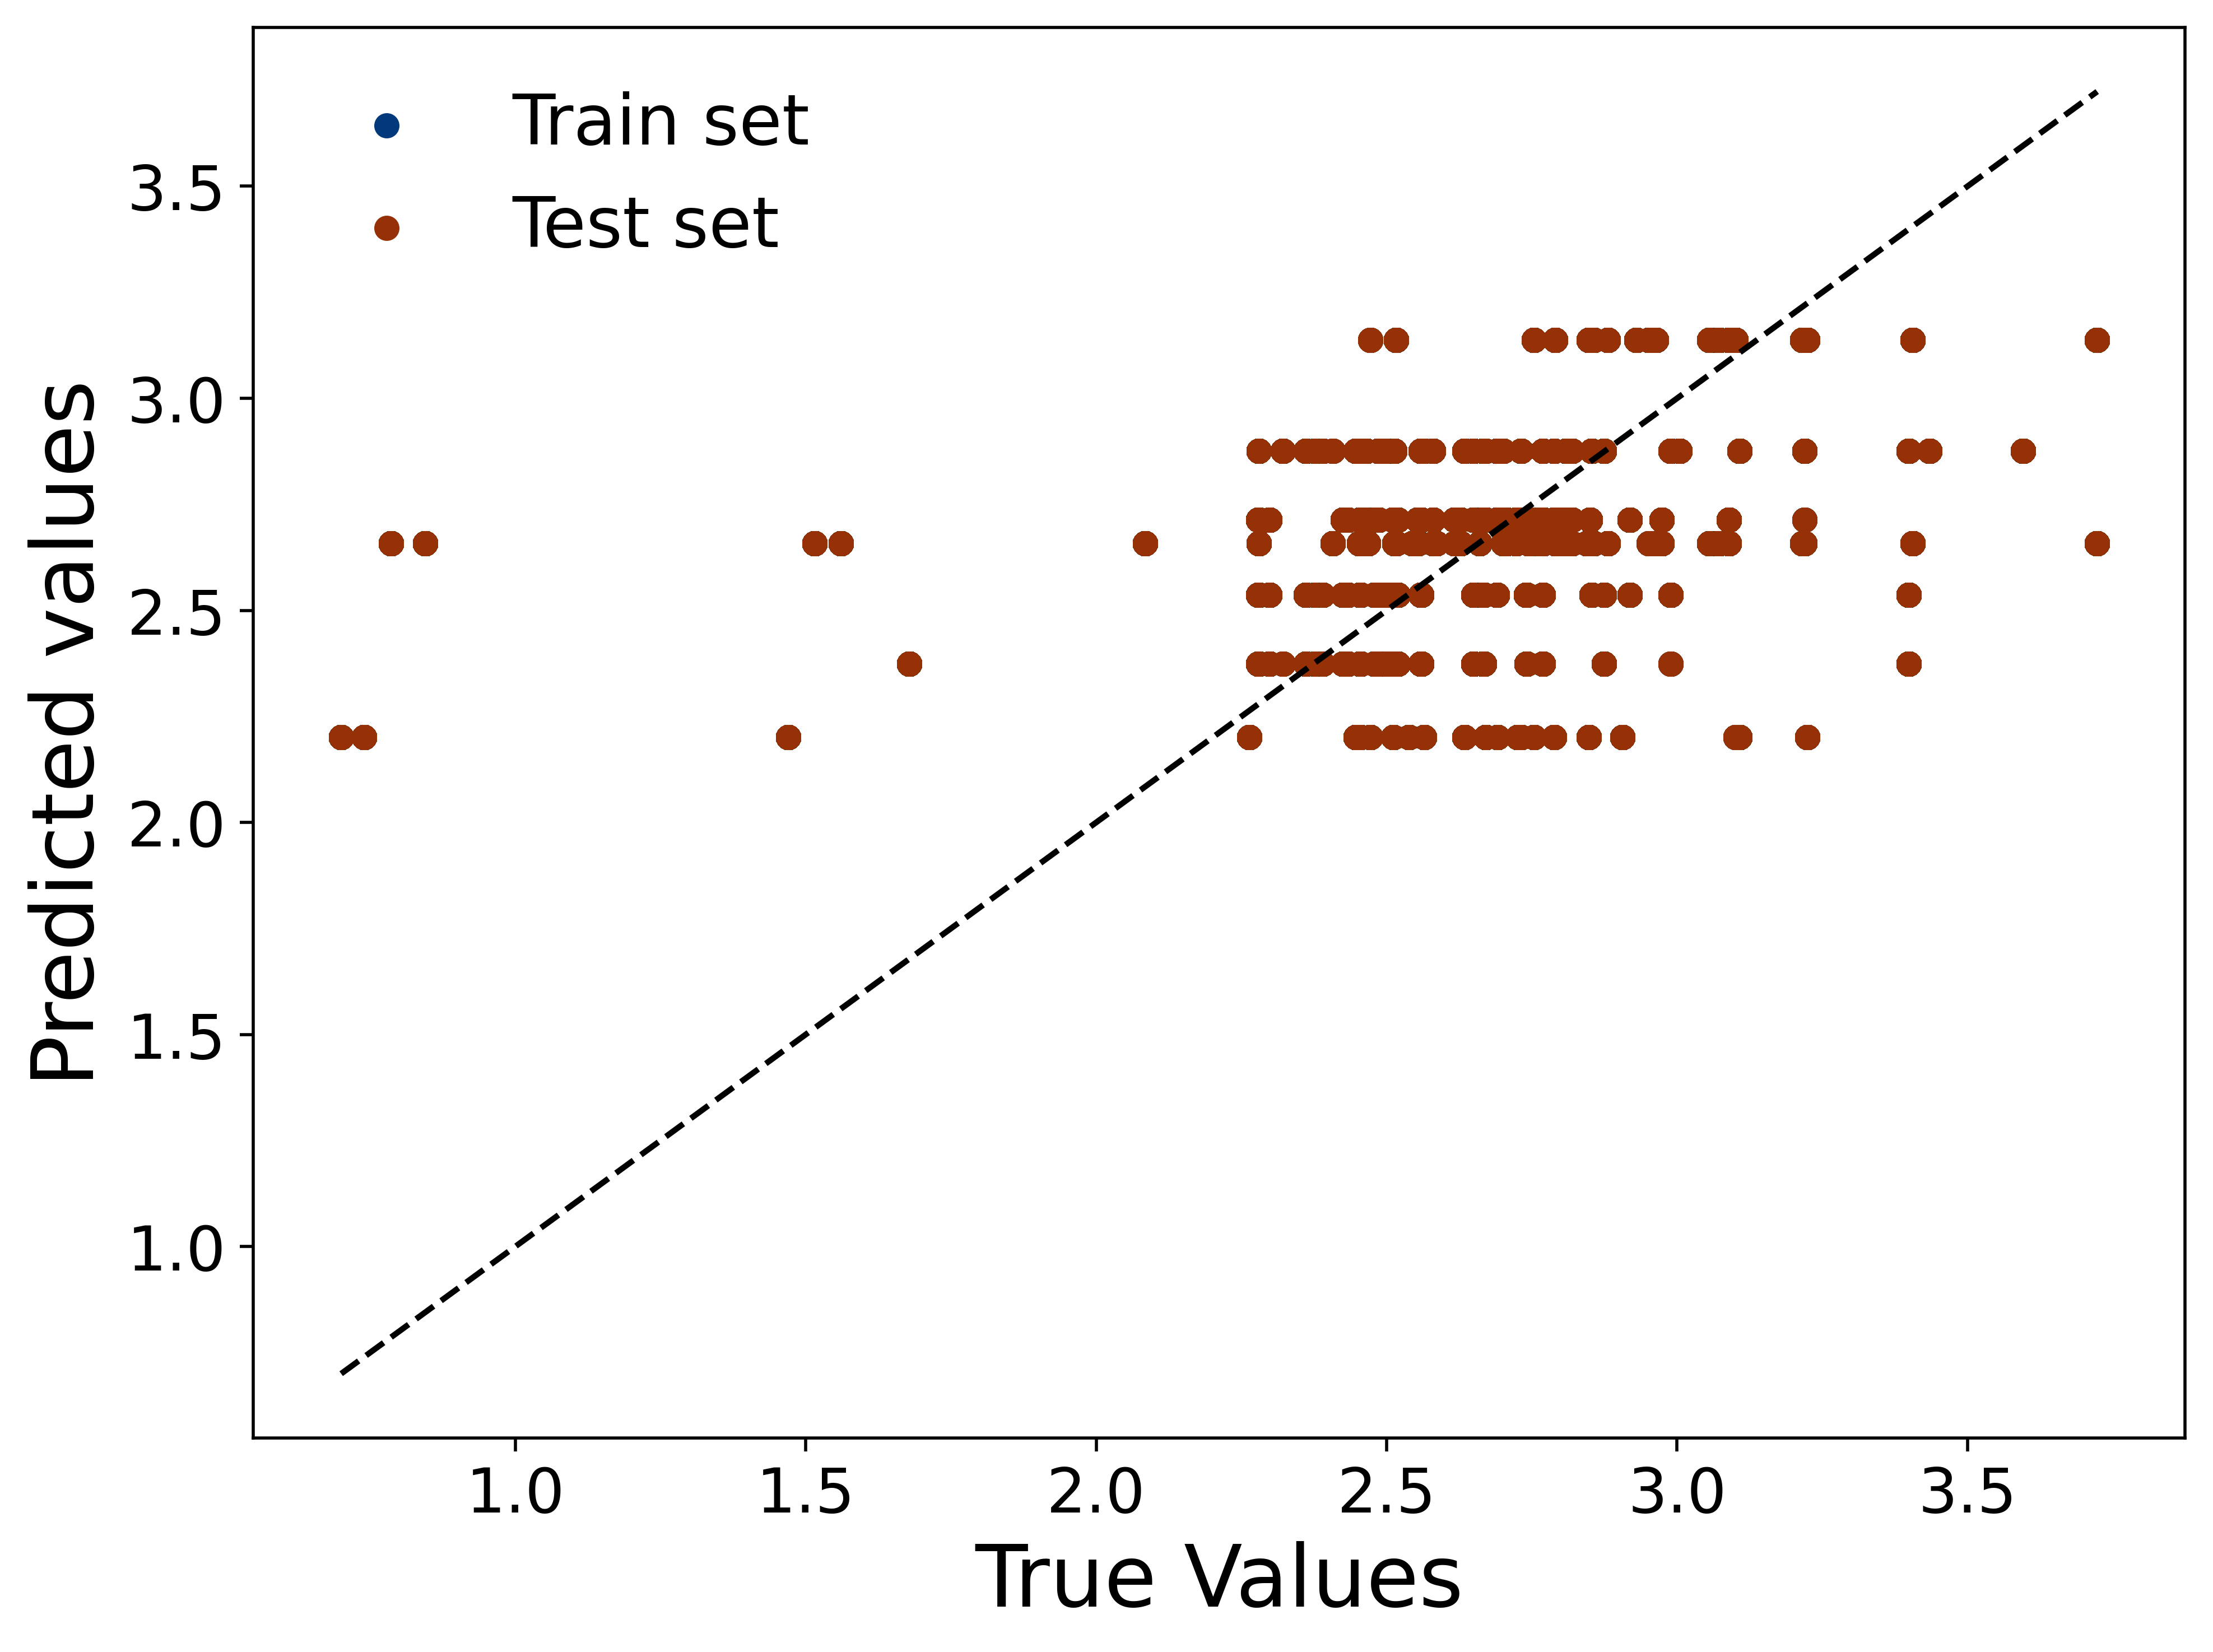

In [16]:
# Parity for DT

colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train_20_e, y_pred_train_20_e, color=train_color, s=30, label='Train set')
ax.scatter(y_test_20_e, y_pred_20_e, color=test_color, s=30, label='Test set')

ax.plot([min(min(y_train_20_e.values), min(y_test_20_e.values)), max(max(y_train_20_e.values), max(y_test_20_e.values))],
        [min(min(y_train_20_e.values), min(y_test_20_e.values)), max(max(y_train_20_e.values), max(y_test_20_e.values))],
        color='black', linestyle='--')

ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.legend(fontsize=18, frameon = False, loc='upper left')

fig.set_dpi(500)

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_DT_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


Random Forest

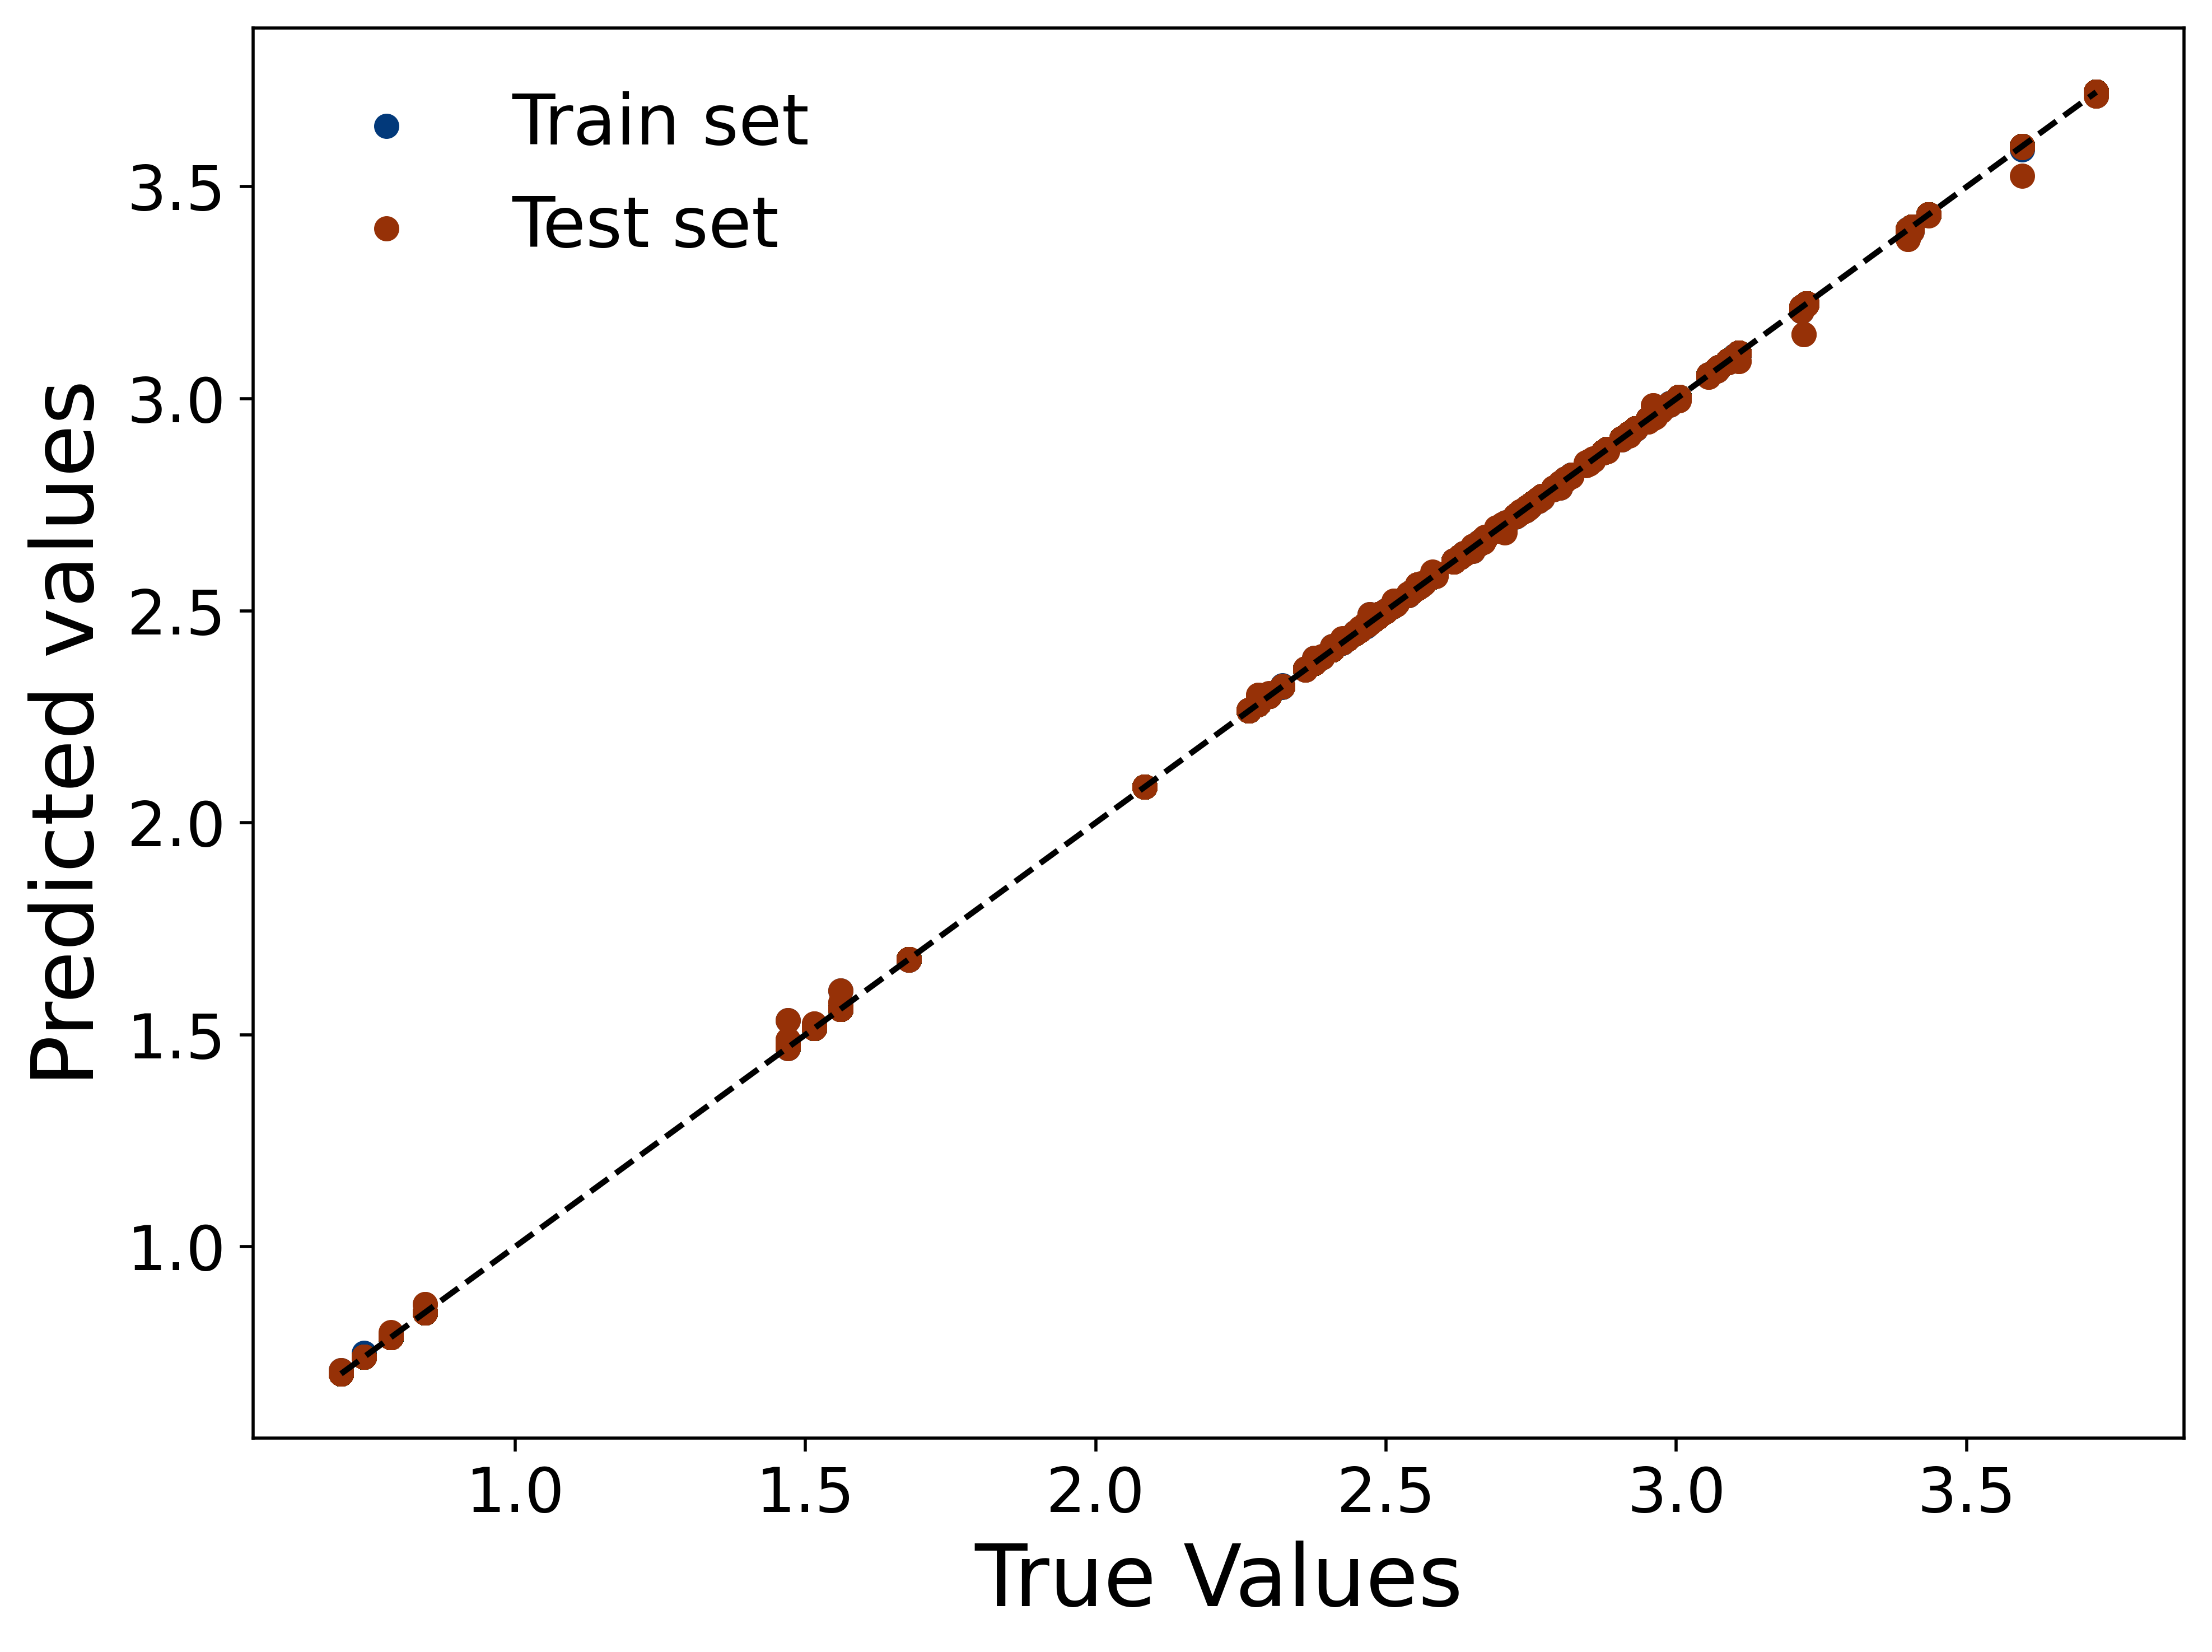

In [22]:
# Parity - RF
colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train_20_e, y_pred_train_20_e, color=train_color, s=30, label='Train set')
ax.scatter(y_test_20_e, y_pred_20_e, color=test_color, s=30, label='Test set')

ax.plot([min(min(y_train_20_e.values), min(y_test_20_e.values)), max(max(y_train_20_e.values), max(y_test_20_e.values))],
        [min(min(y_train_20_e.values), min(y_test_20_e.values)), max(max(y_train_20_e.values), max(y_test_20_e.values))],
        color='black', linestyle='--')

ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.legend(fontsize=18, frameon = False, loc='upper left')

fig.set_dpi(500)

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_RF_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


XGBoost

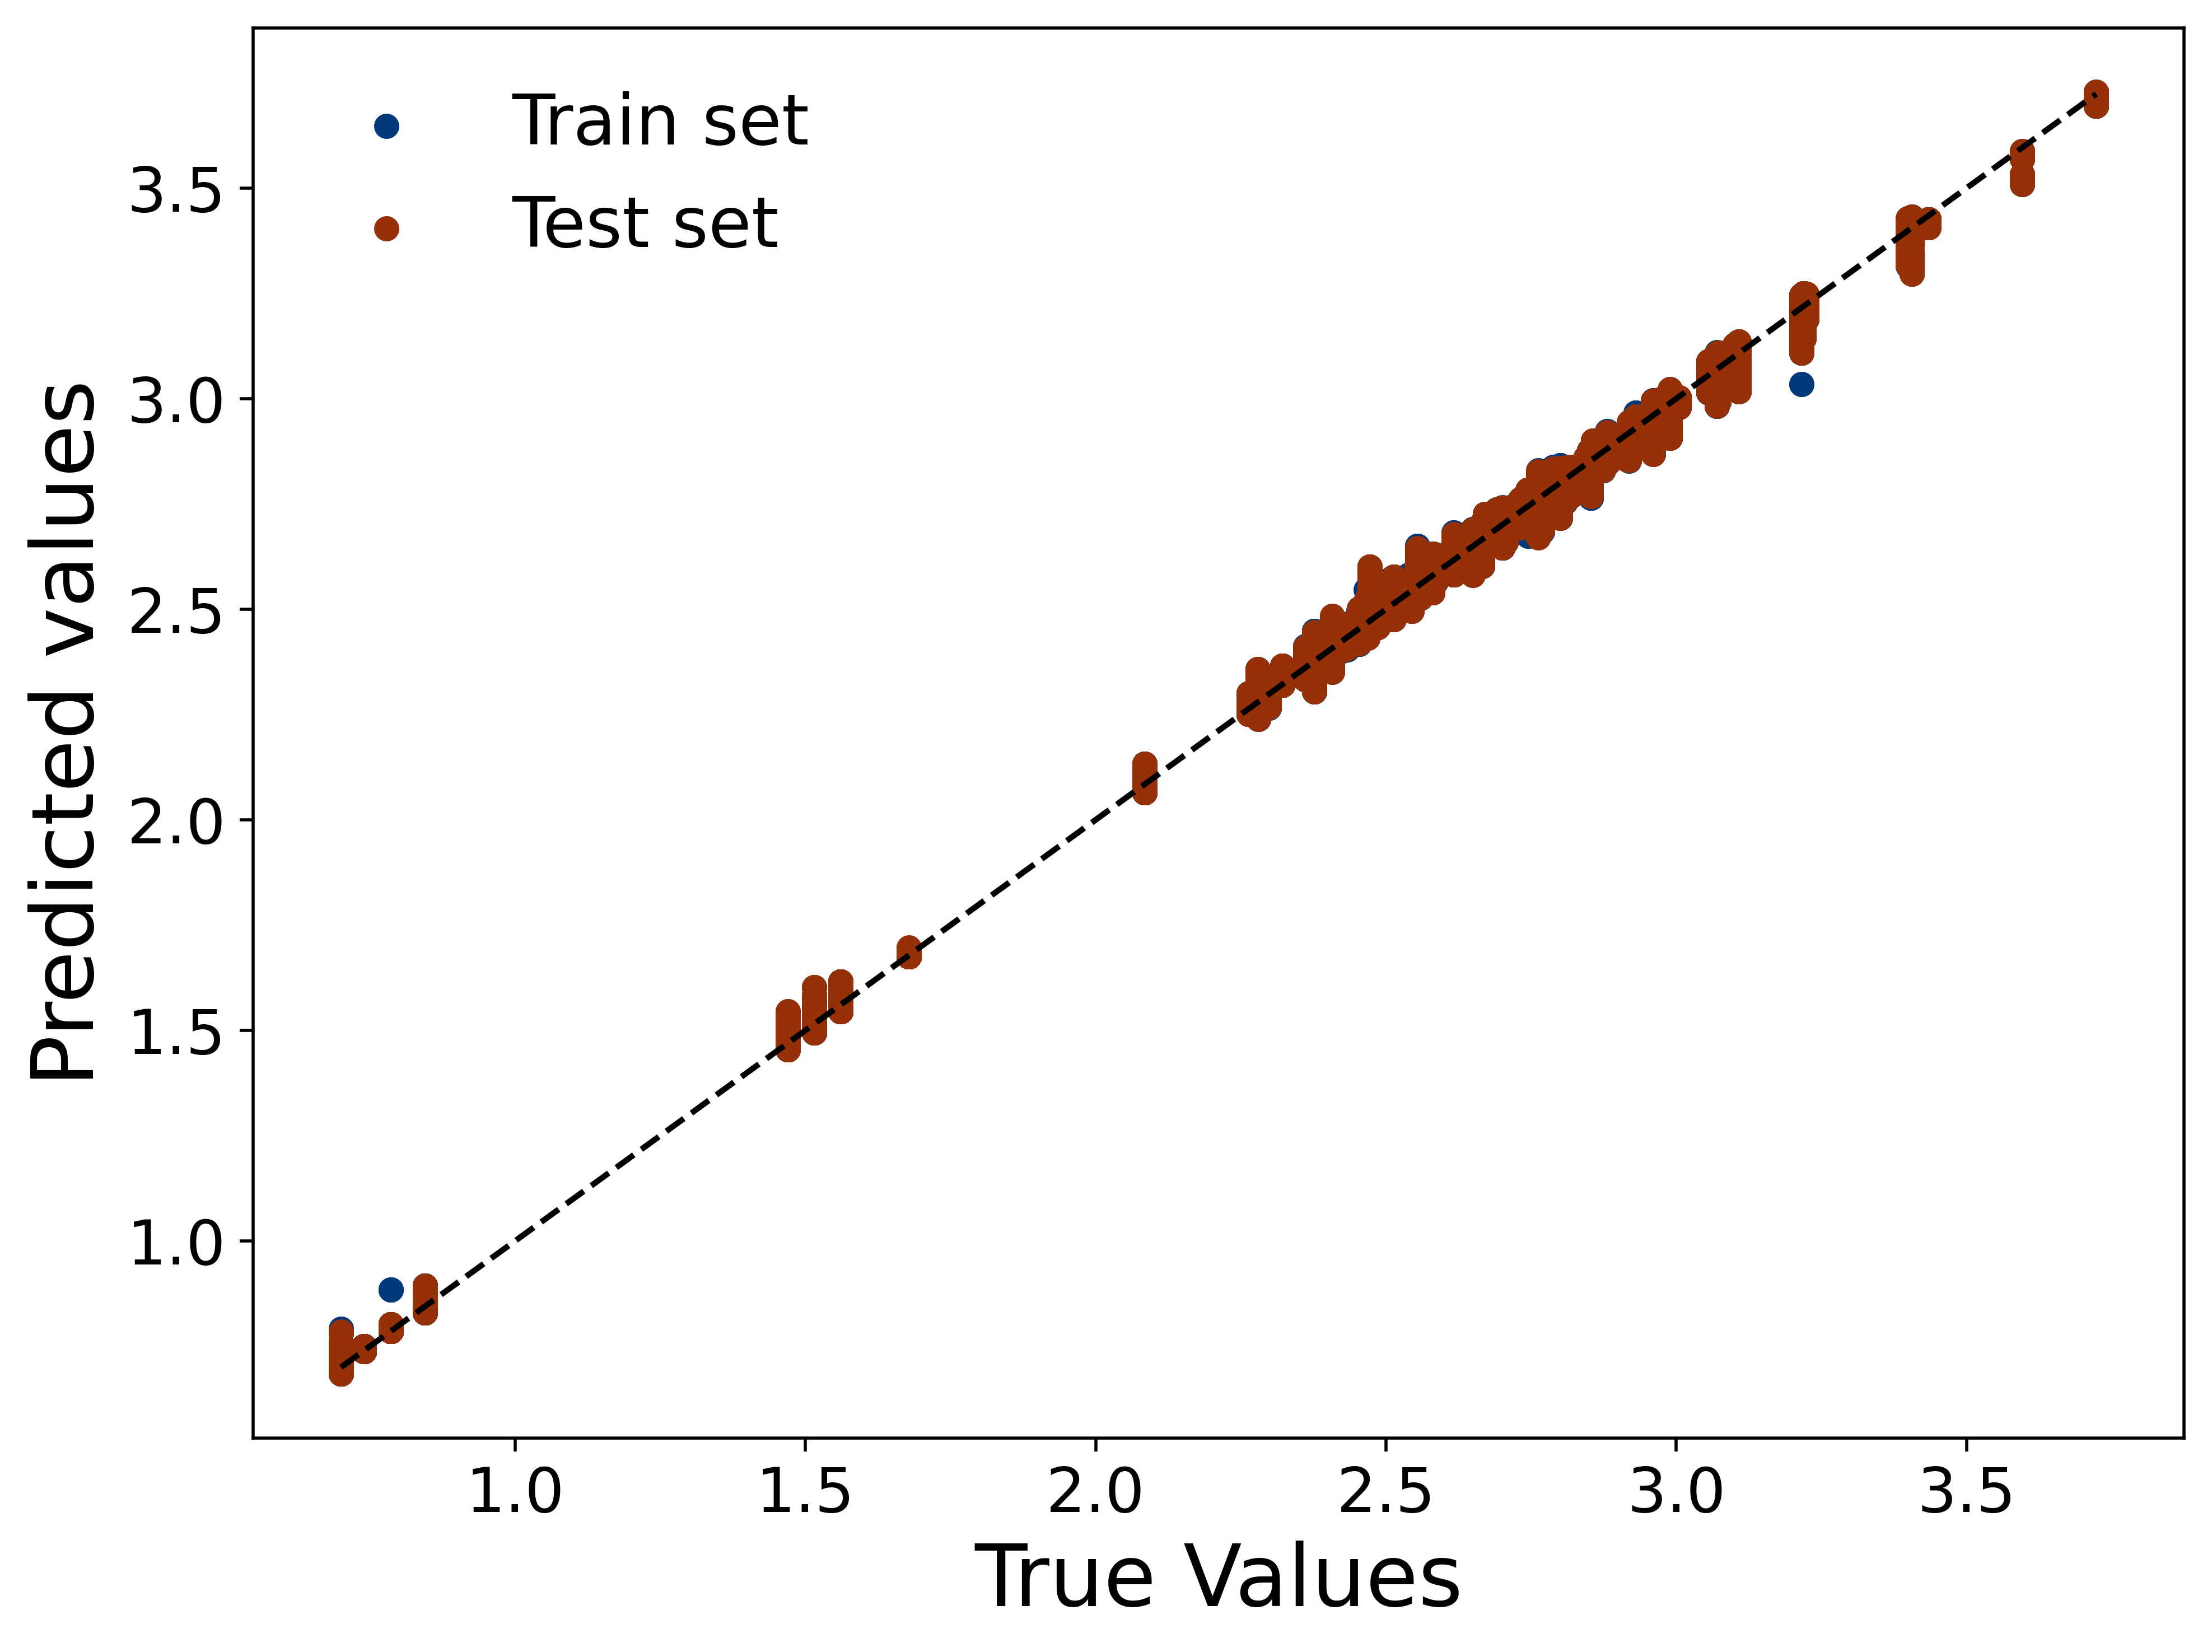

In [19]:
# Parity - XGBoost

colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train_20_e, y_pred_train_20_e, color=train_color, s=30, label='Train set')

ax.scatter(y_test_20_e, y_pred_20_e, color= test_color, s=30, label='Test set')

ax.plot([min(min(y_train_20_e.values), min(y_test_20_e.values)), max(max(y_train_20_e.values), max(y_test_20_e.values))],
        [min(min(y_train_20_e.values), min(y_test_20_e.values)), max(max(y_train_20_e.values), max(y_test_20_e.values))],
        color='black', linestyle='--')

ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.legend(fontsize=18, frameon = False, loc='upper left')

fig.set_dpi(500)

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_XGBoost_20_end.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()
